The link to the full repository is:
https: // github.com / FabianScott / ComSoc
In the folder 'Assignment2'

In [1]:
import pandas as pd

# Contribution Table in proportions
p1 = [0.5, 0.25, 0.25]
p2 = [0.5, 0.25, 0.25]
p3 = [0.25, 0.25, 0.5]
p4 = [0.25, 0.5, 0.25]
p5 = [0.25, 0.5, 0.25]
pd.DataFrame([p1, p2, p3, p4, p5], columns=['Lucas', 'Alexander', 'Fabian'])

,Lucas,Alexander,Fabian
0,0.50,0.25,0.25
1,0.50,0.25,0.25
2,0.25,0.25,0.50
3,0.25,0.50,0.25
4,0.25,0.50,0.25


## Part 1: Mixing Patterns and Assortativity

Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in Week 4.

-----

### Exercise 1:  Mixing Patterns and Assortativity.

##### Loading graph:

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import netwulf as nw
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
def load_graph():
    stylized_network, config, G = nw.load("Graph.json")
    print(G)
    with open('graphdata.pickle', 'rb') as file:
        attribute_dict = pickle.load(file)
    print(*[item for item in attribute_dict.items()][:3], sep='\n')
    nx.set_node_attributes(G, attribute_dict)
    return G

In [3]:
G = load_graph()

Graph with 45188 nodes and 975763 edges
(2122617020, {'_name_': 'Óscar Javier Galindo-caballero', 'top_field': ['Psychology'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})
(78568827, {'_name_': 'Antonio Pais', 'top_field': ['Medicine'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})
(2069946704, {'_name_': 'Nagarjuna Kumarappan', 'top_field': ['Psychology'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})


1. For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [4]:
types_of_top_fields = []

def get_fractions(G, print_statements=False):
    fraction_of_edges_to_same_top_field = []

    for node in G.nodes:
        nodes = 0
        edges = 0
        try: top_fields = G.nodes[node]['top_field']
        except: continue
        if top_fields is None:
            continue
        for top_field in top_fields:
            if top_field not in types_of_top_fields:
                types_of_top_fields.append(top_field)
            for neighbor in G.neighbors(node):
                if "top_field" in G.nodes[neighbor]:
                    if G.nodes[neighbor]['top_field'] is None:
                        pass
                    elif top_field in G.nodes[neighbor]['top_field']:
                        edges += 1
                nodes += 1
        fraction_of_edges_to_same_top_field.append(edges/nodes)

    avg_fraction = sum(fraction_of_edges_to_same_top_field) / len(fraction_of_edges_to_same_top_field)
    if print_statements:
        print("First 10 fractions: ", [round(x, 3) for x in fraction_of_edges_to_same_top_field[:10]])
        print('Average fraction of edges connecting nodes in the same top field:', avg_fraction)
    return avg_fraction

original_avg_fractions = get_fractions(G, print_statements=True)

First 10 fractions:  [0.0, 0.0, 0.138, 0.182, 0.111, 0.176, 0.098, 0.333, 0.333, 0.0]
Average fraction of edges connecting nodes in the same top field: 0.07804470168233815


----
2. Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

Our way of solving this exercise was to make a list of unique types of top fields. We then ran over every single node and randomized the types of top_fields, but keeping the numbers of top_fields the same as before.

In [39]:
types_of_top_fields

['Sociology',
 'Political Science',
 'Computer Science',
 'Engineering',
 'Physics',
 'Mathematics',
 'Medicine',
 'Psychology',
 'Environmental Science',
 'Philosophy',
 'Geography',
 'Biology',
 'Economics',
 'History',
 'Materials Science',
 'Art',
 'Business',
 'Chemistry',
 'Geology']

In [40]:
import random

G_copy = G.copy()
node_list = list(G_copy.nodes())

In [42]:
attribute_dict = {}
for node in G_copy.nodes():
    try: top_fields = G.nodes[node]['top_field']
    except: attribute_dict[node] = {"top_field": None}; continue
    if top_fields is None:
        attribute_dict[node] = {"top_field": None}
    else:
        attribute_dict[node] = {"top_field": random.sample(types_of_top_fields, k=len(top_fields))}

nx.set_node_attributes(G_copy, attribute_dict)
get_fractions(G_copy, print_statements=True)

First 10 fractions:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024, 0.0, 0.0, 0.0]
Average fraction of edges connecting nodes in the same top field: 0.010137278760206899


0.010137278760206899

This gives a much lower average fraction which is also expected as the connection between the nodes have been randomized

----
3. Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

We implement the scipt in 2. in a func

In [55]:
from tqdm import tqdm

def randomize_top_fields(number_of_times):
    values = []
    for i in tqdm(range(number_of_times)):
        G_copy = G.copy()
        node_list = list(G_copy.nodes())
        attribute_dict = {}
        for node in G_copy.nodes():
            try: top_fields = G.nodes[node]['top_field']
            except: attribute_dict[node] = {"top_field": None}; continue
            if top_fields is None:
                attribute_dict[node] = {"top_field": None}
            else:
                attribute_dict[node] = {"top_field": random.sample(types_of_top_fields, k=len(top_fields))}
        nx.set_node_attributes(G_copy, attribute_dict)
        values.append(get_fractions(G_copy))
    return values

def plot_distribution(fractions):
    plt.hist(fractions, bins=20, alpha=0.5, density=True)
    plt.axvline(x=original_avg_fractions, color='r')

    plt.xlabel('Fractions')
    plt.ylabel('Density')
    plt.title('Distribution of fractions of edges connecting nodes in the same top field in a randomized setting')
    plt.show()

In [53]:
fractions = randomize_top_fields(100)

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


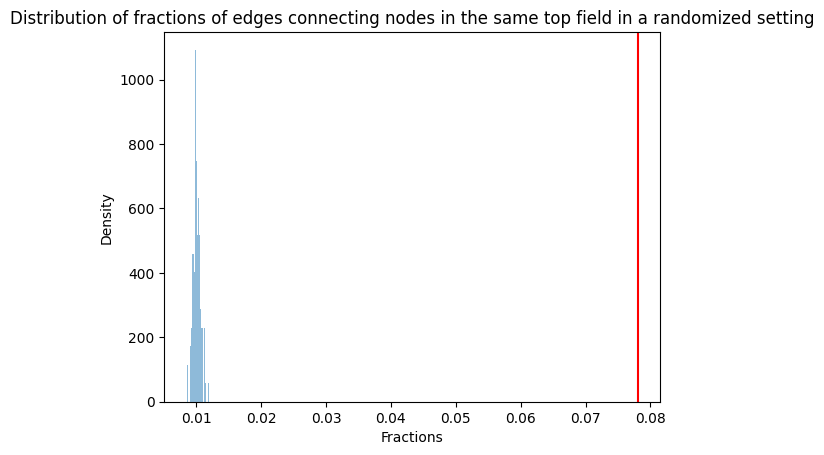

In [56]:
plot_distribution(fractions)

Where the red line is the average fraction in our graph G

In [61]:
mean = np.mean(fractions)
std = np.std(fractions)

print("For randomized settings:")
print("mean: ", mean)
print("std: ", std)
print("\n")

print("original average fraction: ", original_avg_fractions)
if original_avg_fractions < mean-2*std or original_avg_fractions > mean+2*std:
    print("Value is significantly different")
else: 
    print("Value is not significantly different")

For randomized settings:
mean:  0.010106881218046725
std:  0.0005725089237009744


original average fraction:  0.07804470168233815
Value is significantly different


Thereby we can conclude that the chance to connect to a member of the same field is significantly higher than it would be by chance

----
4. Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (Hint: See this paper, eq (2)). Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.

Our own implementation:

In [20]:
def assortativity_coefficient(G):
    degrees = dict(G.degree())
    sum_degrees = sum([deg for node, deg in degrees.items()])
    sum_top_fields = 0

    for u, v in G.edges():
        try: top_field1 = G.nodes[u]['top_field']; top_field2 = G.nodes[v]['top_field']
        except: continue
        if top_field1 is None or top_field2 is None:
            continue
        sum_top_fields += (sum([1 if x == y else 0 for x, y in zip(top_field1, top_field2)])/len([1 if x == y else 0 for x, y in zip(top_field1, top_field2)]))
        
    r = (sum_top_fields - sum_degrees) / (1 - sum_degrees)
    return r

In [21]:
def assortativity_coefficient_alternative(G):
    degrees = dict(G.degree())
    sum_degrees = sum([deg for node, deg in degrees.items()])
    sum_degrees_sq = sum_degrees ** 2
    sum_sq_degrees = sum([deg**2 for node, deg in degrees.items()])
    sum_top_fields = 0

    for u, v in G.edges():
        try: top_field1 = G.nodes[u]['top_field']; top_field2 = G.nodes[v]['top_field']
        except: continue
        if top_field1 is None or top_field2 is None:
            continue
        sum_top_fields += sum([1 if x == y else 0 for x, y in zip(top_field1, top_field2)])
        
    r = (sum_top_fields * sum_degrees - sum_degrees_sq) / (sum_sq_degrees - sum_degrees_sq)
    return r

In [22]:
assortativity_coefficient(G), assortativity_coefficient_alternative(G)

(0.9909350379831158, 0.9908555414023319)

We get an extremely high in both of our implementations. We tried to make another alternative as we found that the first implement was very high, but the second implementation (which is very much alike, but uses another formula) seems to be just as high. This convinces us that the assortative mixing is near perfect when it comes to top_fields. This means that the individuals in the graph has a extremely high tendency to form connections with others who are similar to themselves. 

----
5. Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

To compute this we can simply use networkx implementation, which should work completely fine for this problem:

In [8]:
r = nx.degree_assortativity_coefficient(G)
print(f"Assortativity coefficient r = {r:.3f}")

Assortativity coefficient r = 0.575


As we were unsure if our own function was needed we also created this:

In [23]:
def degree_assortativity_coefficient(G):
    degrees = dict(G.degree())
    sum_degrees = sum([a*b for a,b in zip(degrees.values(), degrees.values())])
    equal_degree, not_equal_degree = 0, 0
    degree_assortativity = 0
    for u, v in G.edges():
        if degrees[u] == degrees[v]:
            equal_degree += 1
            degree_assortativity += degrees[u] * degrees[v]
        not_equal_degree += 1

    r = (degree_assortativity - sum_degrees) / (1 - sum_degrees)
    print(f"Number of equal degrees: {equal_degree}")
    print(f"Number of not equal degrees: {not_equal_degree}")
    return r

print(f"Assortativity coefficient r = {degree_assortativity_coefficient(G):.3f}")

Number of equal degrees: 13099
Number of not equal degrees: 975763
Assortativity coefficient r = 0.566


We can see that our implementation gives nearly the same value as networkx' implementation. This could be due to them using another formula and to the fact that this value has some small error around it.

A value of .566 shows that the graph assortative with respect to the degree is decently high, although not as high as top_fields. High degree scientist often link to other high degree scientist, but there is also a bunch of connections between high degree and low degree scientists, or at least where the degree is different. The value shows that this assortative is stronger than a completely random/useless assortative which would have a value of around 0. (or actually closer to .1 as we saw in above in the randomized settings).

----

## Part 2: Communities

#### In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). 
#### The dataset is available in NetworkX, by calling the function karate_club_graph

---------

##### 1. Visualize the graph using netwulf. Set the color of each node based on the club split (the information is stored as a node attribute).

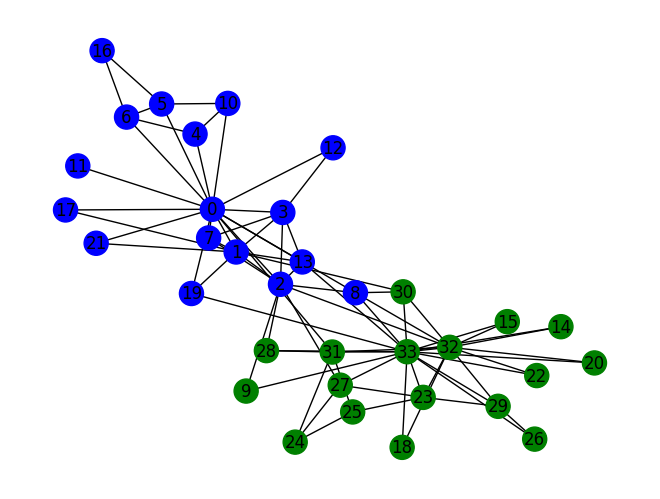

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

club = nx.get_node_attributes(G, "club")

color_map = []
for node in G.nodes():
    if club[node] == "Mr. Hi":
        color_map.append("blue")
    else:
        color_map.append("green")

MrHiGroup = []
OfficerGroup = []
for i in range(len(color_map)):
    if club[i] == "Mr. Hi":
        MrHiGroup.append(i)
    else:
        OfficerGroup.append(i)

nx.draw(G, with_labels=True, node_color=color_map)
plt.show()


--------
##### 2. Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function takes in a networkX Graph and a partitioning as inputs and return the modularity.

In [2]:
def modularity(G, communities):
    m = G.number_of_edges()
    q = 0.0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc/m - (kc/(2*m))**2
    return q

------

##### 3. Explain in your own words the concept of modularity:

Modularity is a number that determines how well some communities (partitions) is distributed in a graph (communities). The higher the modularity, the better the communities have been split up. If the modularity is 0, then there is only 1 community. If modularity is negative, then all nodes are their own community.

-------
##### 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a node attribute, called "club".

In [3]:
modularity_from_current_communities = modularity(G, [OfficerGroup, MrHiGroup])
modularity_from_current_communities


0.3582347140039447

-------

##### 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from. To do so, we will implement the double edge swap algorithm. The double edge swap algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.

    a. Create an identical copy of your original network.
    b. Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
    c. If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
    Repeat steps b. and c. to achieve at least N swaps (I suggest N to be larger than the number of edges).

##### N is chosen to simply just be higher than number of edges. This could also have been even higher, but times 2 is reasonable

In [4]:
N = G.number_of_edges()*2

In [5]:
import random

def double_edge_swap_algo(G_original, N):
    G = G_original.copy()
    for i in range(N):
        u, v = random.choice(list(G.edges()))
        x, y = random.choice(list(G.edges()))

        if (u != x) and (v != y) and (not G.has_edge(u, y)) and (not G.has_edge(x, v)):
            # perform the double edge swap
            G.remove_edges_from([(u, v), (x, y)])
            G.add_edges_from([(u, y), (x, v)])
    
    return G


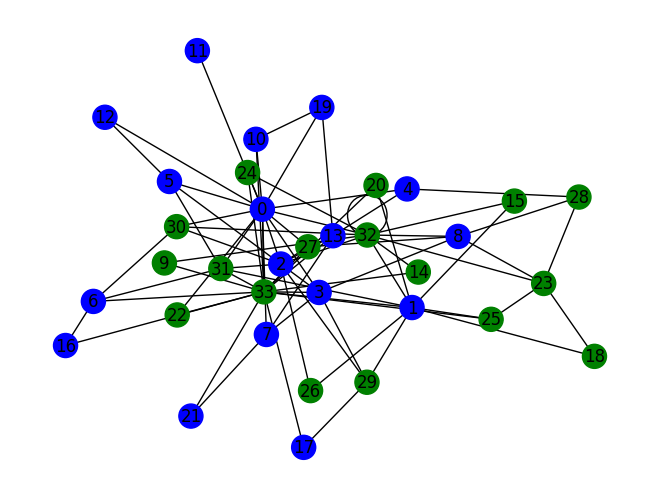

In [6]:
G_double_edge_swap = double_edge_swap_algo(G, N)
nx.draw(G_double_edge_swap, with_labels=True, node_color=color_map)
plt.show()

-------

##### 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same. The two following lists should be the same:

In [7]:
lst_old = [d for n, d in G.degree()]
lst_new = [d for n, d in G_double_edge_swap.degree()]

print("Original degree sequence: ", lst_old)
print("New degree sequence: ", lst_new)
print("Number of errors: ", sum([True for i in range(len(lst_old)) if lst_old[i] != lst_new[i]]))

Original degree sequence:  [16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
New degree sequence:  [16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
Number of errors:  0


In [8]:
# new_modularity for double edge swap
modularity(G_double_edge_swap, [OfficerGroup, MrHiGroup])

-0.0007396449704142605

-----
#### 7, 8 and 9. is all solved in this one function: is_significantly_dif_from_zero

##### 7. Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
##### 8. Compute the average and standard deviation of the modularity for the random network.
##### 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

In [15]:
# function to find if modularity is significantly different from 0

import numpy as np

number_of_iterations = 1000
coms = [OfficerGroup, MrHiGroup]

def plot_density(modularities, value):
    plt.hist(modularities, bins=50, alpha=0.5, density=True)
    plt.axvline(x=value, color='r')

    plt.xlabel('Modularity')
    plt.ylabel('Density')
    plt.title('Distribution of Random Modularities with Actual Modularity')
    plt.show()
    

def is_significantly_dif_from_zero(G, value):

    print("current modularity = ", value)

    modularities = []
    for i in range(number_of_iterations):
        current_double_edge_swap = double_edge_swap_algo(G, N)
        current_modularity = modularity(current_double_edge_swap, coms)
        modularities.append(current_modularity)
    
    mean = np.mean(modularities)
    std = np.std(modularities)

    print("mean: ", mean)
    print("std: ", std)

    plot_density(modularities, value)

    if value < mean-2*std or value > mean+2*std:
        print("Value is significantly different")
    else: 
        print("Value is not significantly different")



current modularity =  0.3582347140039447
mean:  -0.0013505807795268978
std:  0.047414090879488426


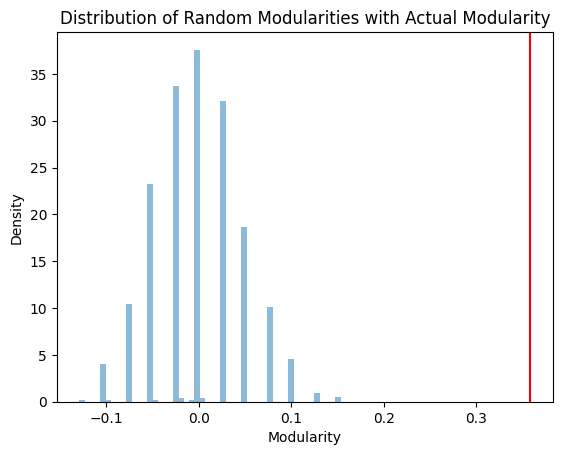

Value is significantly different


In [16]:
is_significantly_dif_from_zero(G, modularity_from_current_communities)

-----
##### 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

##### The high modularity score indicates that the partition is better than a random partition, but there is no way of knowing how good or if it is the best. We would argue that this partition is pretty decent, but certainly not the best as we will soon see.
##### Performing this randomization experiment makes it clear whether or not this partition is significantly different from a random partitioning. It therefore makes it pretty obvious that this club split is much better than a random partitioning.
##### It is pretty important to preserve the nodes degree simply because degree distribution can have a pretty large effect on modularity, and we want to make sure that any observed differences in modularity is not due to difference in degree distribution. This allows us to test hypothesis about the structure and behaviour of the network

-----
##### 11. Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [11]:
import community

partition = community.best_partition(G)
partitions = {}
for i in range(len(partition)):
    group = list(partition.values())[i]
    if group in partitions.keys():
        partitions[group] += [i]
    else:
        partitions[group] = [i]

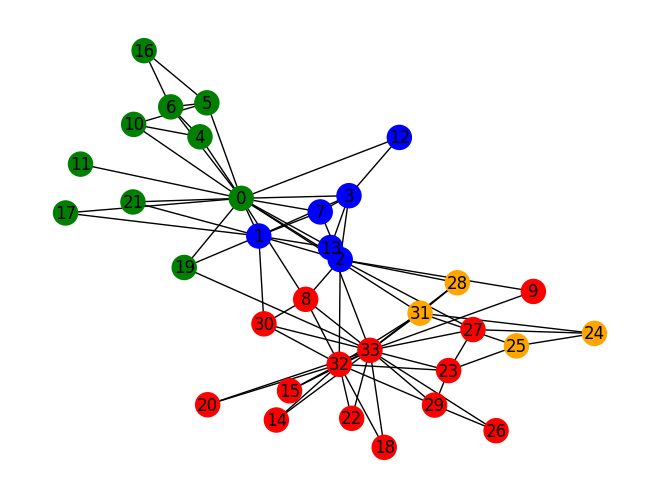

In [14]:
louvain_partitions = list(partitions.values())
louvain_colors = []

for i in range(len(partition)):
    if i in louvain_partitions[0]:
        louvain_colors.append("green")
    if i in louvain_partitions[1]:
        louvain_colors.append("blue")
    if i in louvain_partitions[2]:
        louvain_colors.append("red")
    if i in louvain_partitions[3]:
        louvain_colors.append("orange")

nx.draw(G, with_labels=True, node_color=louvain_colors)
plt.show()


current modularity =  0.39045036160420765
mean:  -0.002291191242989509
std:  0.04662910534744287


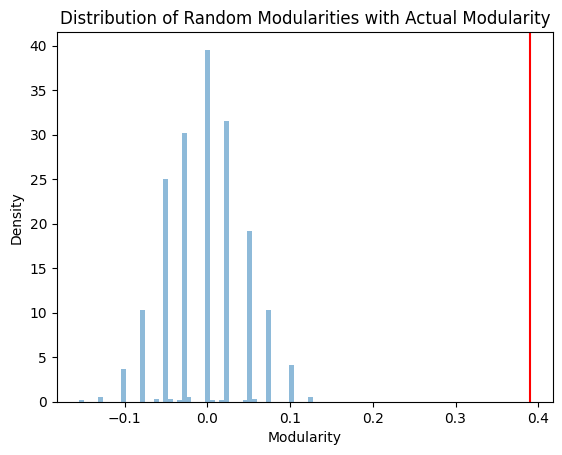

Value is significantly different


In [17]:
louvain_modularity = modularity(G, louvain_partitions)
is_significantly_dif_from_zero(G, louvain_modularity)

In [19]:
print("Louvain modularity: ", louvain_modularity)
print("Original modularity: ", modularity_from_current_communities)
print("Is louvain higher than original? ", louvain_modularity > modularity_from_current_communities)
print("Difference: ", louvain_modularity - modularity_from_current_communities)

Louvain modularity:  0.39045036160420765
Original modularity:  0.3582347140039447
Is louvain higher than original?  True
Difference:  0.032215647600262964


##### Answering the questions: Is it higher or lower than what you found above for the club split? What does this comparison reveal?
##### Yes, the Louvain modularity is a bit higher than the original modularity. This comparison simply just reveals that the louvain algorithm found a better partitioning (group split) than the club split. This means that there are a better way of splitting the data to gain a higher modularity than the club split

-----
##### 12. Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A), where A is the number of communities found by Louvain. We set entry D(i,j) to be the number of nodes that community i has in common with group split j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [63]:
# number of communities from louvain is 4
D = np.ndarray((2, 4))
D

array([[0., 0., 1., 0.],
       [0., 1., 1., 1.]])

Text(0.5, 1.0, 'Alike in louvain and club group')

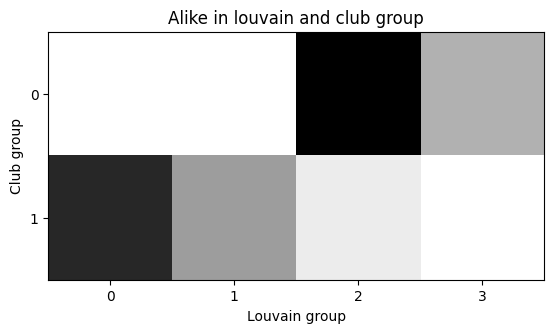

In [70]:
club_split = [OfficerGroup, MrHiGroup]

for i in range(len(club_split)):
    current_club = club_split[i]
    for j in range(len(louvain_partitions)):
        current_partition = louvain_partitions[j]
        alike = sum([True for x in range(len(current_partition)) if current_partition[x] in current_club])
        D[i, j] = alike

plt.imshow(D, cmap='binary')
plt.xlabel("Louvain group")
plt.xticks([0, 1, 2, 3])
plt.ylabel("Club group")
plt.yticks([0, 1])
plt.title("Alike in louvain and club group")



It seems that the louvain groups have split each club into two smaller groups, with one bigger and one smaller group. It seems to be fit the club split partitioning pretty well, as every club is split into two groups. Louvain group two is the only group, which has nodes from both clubs.

In [3]:
import os
from tqdm import tqdm
import random
import numpy as np
import netwulf as nw
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
# if os.getcwd()[-1] in '0123456798':
#     path_parent = os.path.dirname(os.getcwd())
#     os.chdir(path_parent)

In [4]:
# Load the graph
stylized_network, config, G = nw.load("Graph.json")

In [5]:
# Compute the communities
partition = nx_comm.louvain_communities(G)

In [6]:
# Create a list of the number of nodes in each community
sizes = [len(c) for c in partition]
print(f'The average community size is {round(np.mean(sizes),2)}, with a standard deviation of {round(np.std(sizes),2)}. The largest is of size {np.max(sizes)} and the smallest {np.min(sizes)}')

The average community size is 50.21, with a standard deviation of 199.77. The largest is of size 2732 and the smallest 1


In the next section we colour the communities based on their size, which in the case of the largest communities will result in different colours as seen in the output above.

In [24]:
# Create an np array of nodes to use for finding their positions in the graph's list
G_where = np.array(G.nodes)
# Initialize the array for colours and the values for which to colour
degreeColor = np.empty(len(G_where), dtype=object)
valueToPlot = np.log10(sizes)
# we rescale the colours to be in the RGB format (0 to 255 for three colours)
valueToPlotRescaled = 255*(valueToPlot - np.min(valueToPlot))/np.max(valueToPlot)

for size, c in zip(sizes, partition):
    for node in c:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % (int(size), 0, 50)
        degreeColor[np.where(G_where == node)] = color
# zip it up into a dictionary and set it as node attribute
dictionaryColor = dict(zip(list(G.nodes), degreeColor))
nx.set_node_attributes(G, dictionaryColor, 'group')

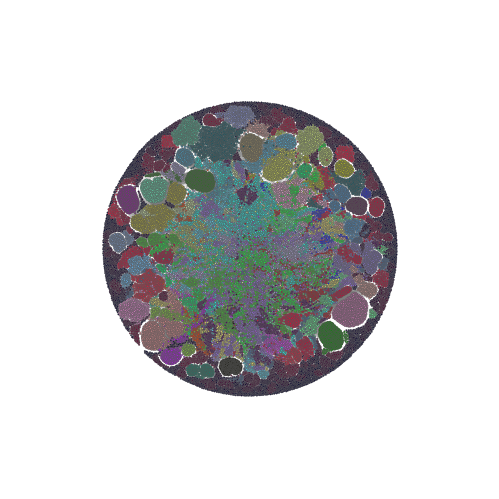

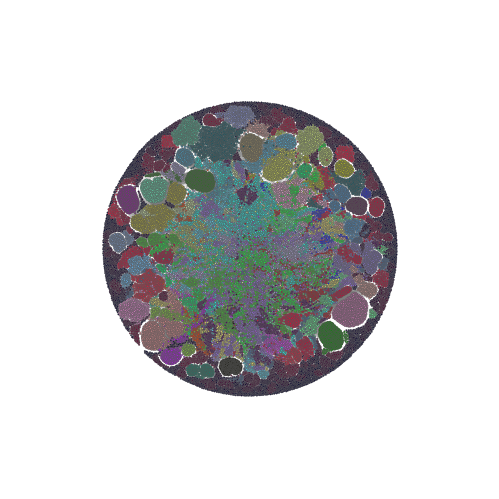

In [25]:
# Use netwulf to draw the graph with the coloured nodes
network, config = nw.visualize(G, config={'zoom':0.6, 'node charge':-15, 'node gravity': 0.7})
fig, ax = nw.draw_netwulf(network)
plt.savefig('Graph_coloured_')

Looking at the graph, we clearly see some large communities of authors, along with a background of smaller communities.

In [5]:
# Redefine the modularity function as this was done in separate notebooks which were concatenated
def modularity(G, communities):
    m = G.number_of_edges()
    q = 0.0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc/m - (kc/(2*m))**2
    return q

In [ ]:
modularity_from_current_communities = modularity(G, partition)

current modularity =  0.9231428593851565


The modularity is rather far from 0 and close to 1, indicating that the graph is very strongly split up into different communities.

# Exercise 4

In [43]:
import os
import numpy as np
import pandas as pd
import netwulf as nw
import networkx.algorithms.community as nx_comm

from collections import Counter
from ast import literal_eval
from tqdm import tqdm
from IPython.display import clear_output

# Fixing the path:
if os.getcwd()[-1] in '0123456798':
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)

In [1]:
stylized_network, config, G = nw.load("BigData/Graph.json")

# Finding the louvain communities of our Graph:
set_seed = 42
communities = nx_comm.louvain_communities(G, seed=set_seed)


# Importing the paper_dataset from a few weeks back:
paper_dataset = pd.read_csv("BigData/paper_dataset.csv", converters={"authorIds": literal_eval, "authorNames": literal_eval})
# Converting the paper_dataset into an authorId lookup by exploding and then setting a new index:
author_lookup = paper_dataset.explode(["authorIds", "authorNames"]).set_index("authorIds").rename(columns={'authorIds': 'authorId'}).dropna()
# Removing the incorrectly exploded authorNames:
author_lookup = author_lookup[author_lookup.index.notnull()]

# Importing the tokenized paper abstracts:
paper_tokens_lookup = pd.read_csv("BigData/paper_tokens_dataset.csv", index_col=0, converters={"Tokens": literal_eval})

# TF-IDF

### What does TF stand for?
TF stands for Term Frequency. It is simply the frequency of a specific term appearing in a document. Therefore the TF is the number of times a word appears in a document, divided by the total number of words in the document.

### What does IDF stand for?
IDF stands for Inverse Document Frequency. The purpose of IDF is to emphasize rarer words, and avoiding the common words like "the" and "and" etc. The IDF is the log of the number of documents divided by the number of documents that contain the word. The more documents that contain a word, the lower the word's IDF, and the less important that word is.

In [ ]:
# Defining global counters to keep track of missing authors and papers:
missing_authors = 0
missing_papers = 0

# Get a list of all the papers authored by the authors in a community:
def get_papers_to_check(community: list) -> list:
    global missing_authors
    papers_to_check = []
    print("Getting papers from authorId...")
    for author_id in tqdm(community):
        try: papers_to_check.extend(author_lookup.loc[str(author_id)]["paperId"].tolist())
        except: missing_authors += 1
    return papers_to_check

# Get a list of all the tokens from each paper in a list:
def get_tokens_from_papers(papers_to_check: list) -> list:
    global missing_papers
    total_tokens = []
    print("Getting tokens from papers...")
    for paper_id in tqdm(papers_to_check):
        try: total_tokens.extend(paper_tokens_lookup.loc[paper_id]["Tokens"])
        except: missing_papers += 1
    return total_tokens

# Get the total tokens for each community in the list:
def generate_token_groups(communities):
    paper_groups = []
    token_groups = []
    for idx, community in enumerate(communities):
        print(f"Generating token groups... {idx + 1} of {len(communities)}\n")
        papers_to_check = get_papers_to_check(list(community))
        paper_groups.extend(papers_to_check)
        token_groups.extend(get_tokens_from_papers(papers_to_check))
        clear_output()
    print(f"All {len(communities)} communities successfully generated.")
    return token_groups, paper_groups

In [ ]:
# It takes way too much time to genereate all the ~600 token groups, so I opted to just generate the top 10 and ignore the rest.
# Finding the top 10 communities by author count:
sorted_args = np.array([len(community) for community in communities]).argsort()[::-1]
top_communities = [communities[i] for i in sorted_args[:10]]

print("Top 10 communities by author count:", [(len(communities[i])) for i in sorted_args][:10])

Top 10 communities by author count: [2594, 2469, 1819, 1574, 1326, 1026, 1006, 1005, 981, 977]


In [ ]:
# Generating token groups for each of the top communities:
top_communities_tokens, top_communities_papers = generate_token_groups(top_communities)

All 10 successfully generated.


In [ ]:
# Reformatting the top_communities_tokens and saving it:

# Zips the all unique tokens with their # of occurences in the list:
zipped_unique = lambda lister: zip(*np.unique(lister, return_counts=True))
# Sorts the zipped list by the second element in descending order:
sorter = lambda zipper: sorted(zipper, key=lambda x: x[1], reverse=True)
# Making the sorted dicts for each top community:
top_communities_tokens_uniquecount = [dict(sorter(zipped_unique(i))) for i in top_communities_tokens]

# Making it into a dataframe:
tokens_df = pd.DataFrame({"Communities": top_communities, "PaperIds": top_communities_papers, "Tokens": top_communities_tokens_uniquecount})
# tokens_df.to_csv("BigData/top_community_tokens.csv")

In [ ]:
# This is just the dataframe that's going to be used going forwards since it's already been generated based on the previous approach:
tokens_df = pd.read_csv("BigData/top_community_tokens.csv", index_col=0, converters={"Communities": literal_eval, "PaperIds": literal_eval, "Tokens": literal_eval})
tokens_df

,Communities,PaperIds,Tokens
0,"{1409253380, 8085509, 12926984, 115777544, 308...","[19c03d3a03dd21e1dd74c3cd9ca57825d7440d88, b54...","{'patients': 5145, 'data': 4470, 'health': 401..."
1,"{118390786, 35053571, 1867785, 2079686669, 281...","[3528385c6eef96422b4cf7d3a7f87ef59ea12ac1, cc3...","{'data': 5550, 'model': 3909, 'results': 3103,..."
2,"{2252806, 49479696, 1679379, 2809876, 35332118...","[6f80d1ade43ae048763d65c6e8e913d9a31de4be, 8f9...","{'data': 7595, 'information': 3213, 'paper': 3..."
3,"{103301121, 2555924, 2117787677, 46702624, 170...","[34503c0b6a615124eaf82cb0e4a1dab2866e8980, 094...","{'models': 9180, 'model': 8473, 'tasks': 7899,..."
4,"{79101961, 11493385, 2301965, 88317978, 144179...","[c117553b2eac5d02eaac3c9bc33a44fe2e1c3ca7, 857...","{'patients': 341, 'usa': 290, 'ffr': 177, 'cor..."
5,"{103362561, 104681475, 144484357, 113463301, 2...","[dd491b812f8acfec86f855e1cac8ed72ca062b53, 050...","{'gamma-ray': 3693, 'emission': 3463, 'data': ..."
6,"{2090979328, 46567426, 66150403, 2174097413, 1...","[fbfc15492c8e114f2884d7cc11ba21f7f350285f, eca...","{'workshop': 1272, 'intelligence': 1268, 'rese..."
7,"{2153465857, 32350210, 13398019, 3948545, 5103...","[14692c6785ce842eae91eb7cf6fffb0c7bbb805f, 868...","{'model': 1617, 'data': 1364, 'models': 1229, ..."
8,"{1484736514, 3121155, 4771844, 104284168, 2068...","[c7293f9dd2ec3d34edf5331eb5a6ad7614723197, 2ff...","{'emotions': 83466, 'interventions': 56043, 'r..."
9,"{145199105, 1761281, 48494598, 51390475, 49647...","[b13799435551d4f2b45f46ebb59e481baf42b11c, e8f...","{'research': 10436, 'health': 10034, 'original..."


### Describe similarities and differences between the communities:
There are some generic similarities between the communities, all of them have the "data" token in their top most frequent, similarly "model", "models", "patients", "research", "paper", etc. are also words that come up a lot and are all clearly words generally related to the topic of scientific research. But in the top 3 there are also some differences. Community 5 mentions "gamma-ray" and "emission", while community 6 
mentions "workshop" and "intelligence", and community 8 focuses on "emotions" and "interventions".

In [ ]:
# TF formula:
TF = lambda term_num, N: (term_num / N) * 100

communities_TFs = []
for token_group in tqdm(tokens_df['Tokens']):
    counts = Counter(token_group)
    TF_dict = dict([(token, TF(count, sum(counts.values()))) for token, count in counts.items()])
    communities_TFs.append(TF_dict)

# Just a little teaser:
print("first 5 in first community:")
list(communities_TFs[0].items())[:5]

100%|██████████| 10/10 [00:37<00:00,  3.73s/it]

first 5 in first community:


[('patients', 0.5563587643536777),
 ('data', 0.48336708973001735),
 ('health', 0.4341652942429574),
 ('results', 0.378475349900461),
 ('model', 0.3625793852046416)]

### Why aren't the TFs not necessarily a good description of the communities?
As mentionend when describing the similarities, there are a lot of generic words related to the topic of scientific research that are to be expected in an abstract. So looking purely at the frequency of words doesn't tell you much.

### Next, we calculate IDF for every word.

In [ ]:
# IDF formula:
IDF = lambda term_occurences, N: np.log10(N / term_occurences)

communities_IDFs = []
for i in tqdm(range(len(tokens_df['Tokens']))):
    counts, papers = Counter(tokens_df['Tokens'][i]), tokens_df["PaperIds"][i]
    IDF_dict = dict([(token, IDF(count, len(papers))) for token, count in counts.items()])
    communities_IDFs.append(IDF_dict)
    
# Just a little teaser:
print("first 5 in first community:")
list(communities_IDFs[0].items())[:5]

100%|██████████| 10/10 [00:00<00:00, 18.82it/s]

first 5 in first community:


[('patients', 0.20131482909240864),
 ('data', 0.2623926850589239),
 ('health', 0.3090146585761606),
 ('results', 0.3686321638405847),
 ('model', 0.38726665476204025)]

### What base logarithm did you use to calculate the IDF? Is that important?
The base of the logarithm is important. Since how the IDF "dampens" depends on the logarithm base, i.e. a smaller base would dampen the frequent terms more, while a bigger base could be preffered if you want to give more weight to rare terms. I chose to go with np.log10 which is the logartithm with base 10, because it felt appropriate for this case, making generic terms less apparent.

### We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:

In [ ]:
communities_TF_IDFs = []
for idx, token_group in enumerate([list(i) for i in tokens_df["Tokens"]]):
    group_TF_IDF = []
    for token in token_group:
        # An error in some cases causes negative IDF values, so I just set them to 0.
        group_TF_IDF.append(communities_TFs[idx][token] * max(0,communities_IDFs[idx][token]))
    communities_TF_IDFs.append(dict(sorter(zip(token_group, group_TF_IDF))))
    
# Just a little teaser:
print("first 5 in first community:")
list(communities_TF_IDFs[0].items())[:5]

first 5 in first community:


[('models', 0.14113037359939387),
 ('research', 0.14106781219015055),
 ('study', 0.14102358371643073),
 ('mortality', 0.1409867230188593),
 ('methods', 0.14058421302837504)]

In [46]:
# Since the last round of neighbors was foud without getting their names and such info, I can
# only display the author ids:
def print_community(community_idx):
    print(f"COMMUNITY {community_idx + 1}:\n")
    print("Top 10 TF terms:")
    print(list(communities_TFs[community_idx])[:10])
    print("Top 10 TF-IDF terms:")
    print(list(communities_TF_IDFs[community_idx])[:10])
    print("Top 3 authors:")
    print(list(tokens_df["Communities"][community_idx])[:3])
    print()

In [47]:
print_community(0)
print_community(1)
print_community(2)

COMMUNITY 1:

Top 10 TF terms:
['patients', 'data', 'health', 'results', 'model', 'study', 'models', 'research', 'mortality', 'methods']
Top 10 TF-IDF terms:
['models', 'research', 'study', 'mortality', 'methods', 'model', 'social', 'using', 'results', 'use']
Top 3 authors:
[1409253380, 8085509, 12926984]

COMMUNITY 2:

Top 10 TF terms:
['data', 'model', 'results', 'paper', 'children', 'social', 'study', 'systems', 'system', 'health']
Top 10 TF-IDF terms:
['results', 'model', 'paper', 'children', 'social', 'study', 'systems', 'system', 'health', 'different']
Top 3 authors:
[118390786, 35053571, 1867785]

COMMUNITY 3:

Top 10 TF terms:
['data', 'information', 'paper', 'model', 'results', 'system', 'social', 'performance', 'problem', 'using']
Top 10 TF-IDF terms:
['results', 'system', 'social', 'performance', 'problem', 'using', 'model', 'study', 'models', 'paper']
Top 3 authors:
[2252806, 49479696, 1679379]



In [48]:
print_community(4)
print_community(5)
print_community(6)

COMMUNITY 5:

Top 10 TF terms:
['patients', 'usa', 'ffr', 'coronary', 'lesions', 'p', 'uk', 'risk', 'clinical', 'group']
Top 10 TF-IDF terms:
['coronary', 'lesions', 'p', 'uk', 'ffr', 'risk', 'clinical', 'group', 'disease', 'bifurcation']
Top 3 authors:
[79101961, 11493385, 2301965]

COMMUNITY 6:

Top 10 TF terms:
['gamma-ray', 'emission', 'data', 'telescope', 'fermi', 'energy', 'large', 'γ-ray', 'gev', 'flux']
Top 10 TF-IDF terms:
['information', 'network', 'high', 'different', 'x-ray', 'paper', 'p.', 'j.', 'distribution', 'present']
Top 3 authors:
[103362561, 104681475, 144484357]

COMMUNITY 7:

Top 10 TF terms:
['workshop', 'intelligence', 'research', 'artificial', 'new', 'learning', 'model', 'systems', 'language', 'workshops']
Top 10 TF-IDF terms:
['data', 'pp', 'reviewed', 'tasks', 'models', 'ai', 'games', 'us', 'safety', 'analysis']
Top 3 authors:
[2090979328, 46567426, 66150403]



In [49]:
print_community(7)
print_community(8)

COMMUNITY 8:

Top 10 TF terms:
['model', 'data', 'models', 'results', 'new', 'social', 'tasks', 'language', 'using', 'cancer']
Top 10 TF-IDF terms:
['original', 'across', 'replication', 'scale', 'development', 'systems', 'research', 'present', 'big-bench', 'performance']
Top 3 authors:
[2153465857, 32350210, 13398019]

COMMUNITY 9:

Top 10 TF terms:
['emotions', 'interventions', 'reappraisal', 'one', 'positive', 'negative', 'effects', 'original', 'effect', 'pandemic']
Top 10 TF-IDF terms:
['low', 'lab', 'among', 'important', 'greater', 'engagement', 'direct', 'extremely', 'showed', 'future']
Top 3 authors:
[1484736514, 3121155, 4771844]



### Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
In some cases they are, for example the word "data" has in all cases gone a few places down the list, but community 6 it has unfortunately lost some of its uniqueness. But I'd still argue that the TF-IDF has helped dampen these most common/generic words, and the new top 10 is a little more informative than the TF top 10.


# Exercise 5

In [5]:
import os
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fixing the path:
if os.getcwd()[-1] in '0123456798':
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)

In [6]:
tokens_df = pd.read_csv('BigData/top_community_tokens.csv', usecols=["Tokens", "Communities"], converters={"Communities": literal_eval, 'Tokens': literal_eval})

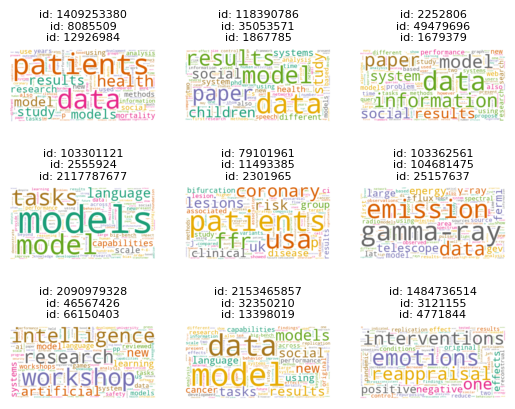

In [7]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=3)
for i, ax in enumerate(axs.flat):
    # Generate a word cloud from the token frequencies
    wordcloud = WordCloud(background_color="white", colormap="Dark2").generate_from_frequencies(tokens_df["Tokens"][i])
    
    # Display the word cloud in the subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    name_list = list(tokens_df["Communities"][i])[:3]
    ax.set_title(f"id: {name_list[0]}\nid: {name_list[1]}\nid: {name_list[2]}", fontsize = 8)
    ax.axis("off")

# Adjust the spacing between subplots and add a title to the figure
fig.subplots_adjust(hspace=.5)
# fig.subplots_adjust(wspace=)
plt.show()

### Comment on your results

Well, based on the shortcomings of the TF-IDF method I chose to just use the TF to make the word clouds, and I think these results are satisfying. They are somewhat telling of what types of fields the groups are related to. The one about "gamma-ray" and "emission" is most likely astronomy etc.

### Look up the top authors in each community



In [28]:
import requests

lister = []
author_list = [list(i)[0] for i in tokens_df["Communities"]]

for id in author_list:
    url = f'https://api.semanticscholar.org/v1/author/{id}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        name = data.get('name')
    else:
        print("author_id missing error")
        continue
    lister.append((id, (name, [paper.get("title") for paper in data.get("papers")])))

In [32]:
df2 = pd.DataFrame(dict(lister)).T
df2

,0,1
1409253380,R. Myers,[TRACE: A Stigmergic Crowdsourcing Platform fo...
118390786,H. Quiroz-Mercado,[Bilateral macular hole formation secondary to...
2252806,S. Pujari,[The influence of social status on consensus b...
103301121,Johann D. Gaebler,"[MATH 112 : HOMEWORK 2 SOLUTIONS, Partially bo..."
79101961,S. Kweon,[Effect and regulatory mechanism of heat shock...
103362561,Xue Fengli,[The Analyzation of the Syndrome Differentiati...
2090979328,P. Thornton,"[Workshop participants, A Peer-reviewed Newspa..."
2153465857,Jing Liu,[Gauging Public Opinion in the Age of Social M...
1484736514,O. Care,"[Joint Intervention on Questions #3 & #4, Crea..."
145199105,M. Messer,[[Report from the supportive ambulatory nursin...


After looking up the top authors and looking at the papers they've released it's not clear whether or not they match the group, but nothing seems completely out of the ordinary.